# Stock Sentiment Analysis from News Headlines

<p>This notebook generates investing insights by applying sentiment analysis on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. Using a natural language processing< technique, we can understand the emotion behind the headlines and predict whether the market <em>feels</em> good or bad about a stock. This enables us to make educated guesses on how certain stocks will perform and trade accordingly.</p>

<p>Why headlines? And why from FINVIZ?</p>
FinViz makes market information accessible and provides a lot of data in visual snapshots.
<li>Headlines, which have similar length, are easier to parse and group than full articles, which vary in length.</li>
<li>FINVIZ has a list of trusted websites, and headlines from these sites tend to be more consistent in their jargon than those from independent bloggers. <b>Consistent textual patterns will improve the sentiment analysis.</b></li>
</ol>
<br>
<p><strong>Disclaimer: Investing in the stock market involves risk and can lead to monetary loss. The content in this notebook is purely for educational purposes and should not to be taken as financial advice.</strong> </p>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
%matplotlib inline
# https://github.com/mariostoev/finviz
import finviz
import nltk
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Tickers of Stocks we want to investigate
TICKER_LIST = ['AMZN', 'GOOG']

## finviz-api

We will be using an unofficial [finviz-API](https://github.com/mariostoev/finviz) made by [Mario Stoev](https://github.com/mariostoev) to get the news headlines for each stock.

finviz.get_news returns list of sets containing containing:
1. Datetime
2. Headline
3. URL
4. Source

In [3]:
def get_news(ticker):
    """
    Returns a list of sets containing news headline and url
    
    :param ticker: stock symbol
    :return: list
    """
    news = finviz.get_news(ticker)
    return news

In [4]:
# Example
e = get_news('AAPL')[0][0]
datetime.strptime(e, '%Y-%m-%d %H:%M').time()

datetime.time(19, 1)

In [5]:
# Hold the parsed news into a list
parsed_news = []

for ticker in TICKER_LIST:
    try:
        news_array = get_news(ticker)
        for news_set in news_array:
            datetime = datetime.strptime(news_set[0], '%Y-%m-%d %H:%M')
            date = datetime.date()
            time = datetime.time()
            headline = news_set[1]
            parsed_news.append([ticker, date, time, headline])
    except:
        pass

In [6]:
parsed_news[:3]

[['AMZN',
  datetime.date(2022, 5, 24),
  datetime.time(17, 27),
  'Report: Almost 1 in 5 Amazon delivery drivers injured last year'],
 ['AMZN',
  datetime.date(2022, 5, 24),
  datetime.time(17, 0),
  'An Amazon worker will make a novel shareholder proposal this week'],
 ['AMZN',
  datetime.date(2022, 5, 24),
  datetime.time(16, 55),
  'Amazon Style Opens Its Very First Store Powered by\xa0Technology']]

## Sentiment analysis is very sensitive to context

For example, "This is so addictive!" often means something positive if the context is a video game you are enjoying with your friends, but it very often means something negative when we are talking about opioids. 

Financial journalists have their own lingo. Let's add some new words and sentiment values to our lexicon to make NLTK think like a financial journalist. 

In [7]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/simplypatrickg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

## Sentiment Classification

[VADER](https://pypi.org/project/vaderSentiment/) (Valence Aware Dictionary and sEntiment Reasoner)is a lexicon and rule-based sentiment analysis tool. Let's use it to quantify how much of positive or negative emotion the text has and also the intensity of emotion.

The tool will generate a compound score, which is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

In [9]:
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = pd.concat([scored_news, scores_df], axis=1)
# Convert the date column from string to datetime
scored_news['date'] = scored_news.date

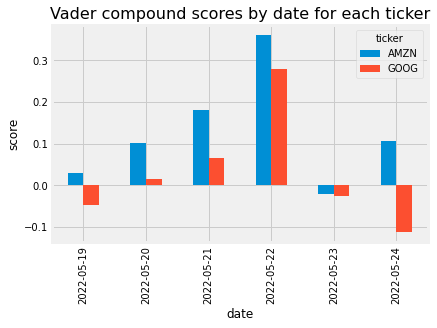

In [10]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
mean_c = mean_c.unstack(level=1)
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis=1)
# Plot a bar chart with pandas
mean_c.plot.bar()
plt.title("Vader compound scores by date for each ticker", fontsize=16)
plt.ylabel("score")
plt.show()

## Handling duplicates

Some headlines are the same news piece from different sources, the fact that they are written differently could provide different perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. Let's get rid of is verbatim copied headlines, as these are very likely coming from the same journalist and are just being "forwarded" around.

In [11]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news['headline'].count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['ticker', 'headline'])
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean['headline'].count()
# Print before and after numbers
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 200 headlines, now we have 199'

## Sentiment on one single trading day and stock¶

Now let's focus on one trading day and one single stock. We will make an informative plot where we will see the smallest grain possible: headline and subscores.

In [12]:
STOCK = TICKER_LIST[0]
DATE = scored_news.date[0]

# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the STOCK row
single_day = single_day.loc[STOCK]
# Select the DATE
single_day = single_day.loc[DATE]
# Set the index to time and 
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()

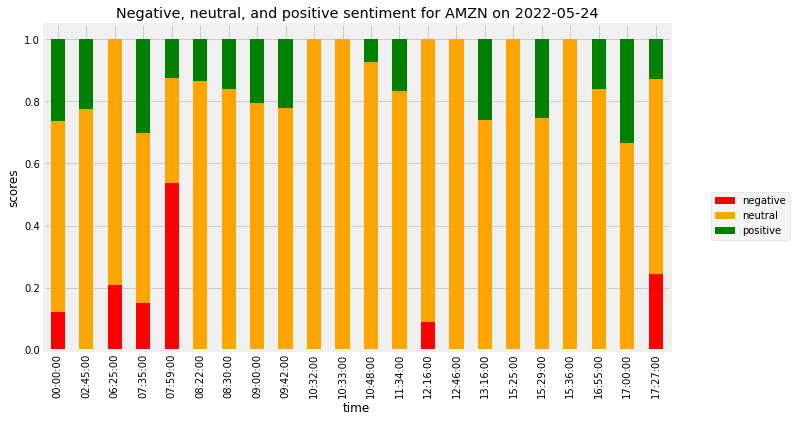

In [13]:
TITLE = f"Negative, neutral, and positive sentiment for {STOCK} on {DATE}"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores")
plt.show()